In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

from matplotlib import cm
from matplotlib.ticker import LinearLocator
from ifu_helpers import *

In [2]:
%matplotlib ipympl

In [3]:
def make_subpupil_mirrors(x, y, d, p):
    """Assume coordinate system has already been transformed to follow the chief
    ray (see alpha, beta, gamma values in p).
    
    Parameters
    ----------
    d: float
        On-axis distance to subpupil mirrors. Must be > 0.
    """
    return conic_3d(x, y, c, k, alpha, beta, 0)

def subpupil_angles():
    alpha = 0
    beta = 0
    return alpha, beta

In [32]:
def conic_3d_sag_critical_x_y(c, k, alpha, beta, gamma):

    alpha = convert_angle(alpha) * np.pi/180
    beta = convert_angle(beta) * np.pi/180
    gamma = convert_angle(gamma) * np.pi/180

    # Determine the off-axis distance
    if (abs(c) > 1e-10):
        # If curvature is very small, it's basically a plane so no need to shift coordinates
        r = 1 / c
        y0 = r*np.sin(alpha) / (1+np.cos(alpha))
        x0 = r*np.sin(beta) / (1+np.cos(beta))

    yc = -1*y0

    sing = np.sin(gamma)
    sin3g = np.sin(3*gamma)
    cosg = np.cos(gamma)
    cos2g = np.cos(2*gamma)

    if k == -1:
        xc1 = -x0 + ( sing*(5 + c*c*yc*yc) + sin3g*(1 + c*c*yc*yc) ) / (cosg*cosg*-8*c)
        xc2 = None

    else:
        arg1 = -1*sing / (c*(1+k)*(-2-k+k*cos2g))
        arg2 = -2 - k + k*cos2g
        arg3 = cosg*k*np.sqrt( (-2+2*c*c*(1+k)+yc*yc) * (-2-k+k*cos2g) )
        
        xc1 = arg1 * (arg2 - arg3) - x0
        xc2 = arg1 * (arg2 + arg3) - x0

    return xc1, xc2, yc

def find_bounded_extremum(x0, y0, p, mode):
    """
    Parameters
    ----------
    x0: float
        Initial guess for x0.
    mode: bool
        True if max, False if min.
    """
    # If x0, y0 are inside gaps then we don't need to go further
    in_xgap, in_ygap = is_inside_slicer_gap(x0, y0, p)
    if in_xgap: return p.gx_depth
    if in_ygap: return p.gy_depth

    # Not inside a gap. We need to compute the sag at the bounds and
    # critical point(s) of the slice.
    # First, compute the bounds of the current slice
    col_num, slice_num = get_slicer_index(x0, y0, p)
    xsize, ysize = get_slicer_size(p)
    alpha, beta, gamma = get_slice_angles(slice_num, col_num, p)

    xlo = col_num * (p.dx + p.gx_width) - xsize/2
    xhi = xlo + p.dx
    ylo = slice_num * (p.dy + p.gy_width) - ysize/2
    yhi = ylo + p.dy

    # Compute critical points
    xc1, xc2, yc = conic_3d_sag_critical_x_y(p.c, p.k, alpha, beta, gamma)

    # There are up to 6 points to compare depending on whether the
    # critical points are within bounds
    zsolns = np.zeros(6)
    zsolns[0] = conic_3d(xlo, ylo, p.c, p.k, alpha, beta, gamma)
    zsolns[1] = conic_3d(xlo, yhi, p.c, p.k, alpha, beta, gamma)
    zsolns[2] = conic_3d(xhi, ylo, p.c, p.k, alpha, beta, gamma)
    zsolns[3] = conic_3d(xhi, yhi, p.c, p.k, alpha, beta, gamma)

    # Number of elements to compare so far
    n_compare = 4

    # Check whether critical points are in bounds. If yes, compute the
    # sag and add to array of points to compare.
    if yc >= ylo and yc <= yhi:
        if xc1 >= xlo and xc1 <= xhi:
            zsolns[4] = conic_3d(xc1, yc, p.c, p.k, alpha, beta, gamma)
            n_compare += 1
        if xc2 is not None:
            if xc2 >= xlo and xc2 <= xhi:
                zsolns[5] = conic_3d(xc2, yc, p.c, p.k, alpha, beta, gamma)
                n_compare += 1

    # Compare potential solutions to get the maximum or minimum
    if mode:
        return np.max(zsolns[:n_compare])
    return np.min(zsolns[:n_compare])

def find_global_extrema_slicer(p):
    """Returns the global max and min of the image slicer.
    """
    # Determine which slice the global extrema are on. To do this, roughly sample
    # the entire image slicer.
    xsize, ysize = get_slicer_size(p)
    nx = p.n_cols * 8
    ny = p.n_rows * p.n_each * 8
    xpts = np.linspace(-xsize/2, xsize/2, nx)
    ypts = np.linspace(-ysize/2, ysize/2, ny)

    x0_max, y0_max, z0_max = 0, 0, -np.inf
    x0_min, y0_min, z0_min = 0, 0, np.inf
    for x in xpts:
        for y in ypts:
            z = make_image_slicer(x, y, p)
            # Update the (x,y) corresponding to the max and min values
            if z > z0_max: x0_max, y0_max, z0_max = x, y, z
            elif z < z0_min: x0_min, y0_min, z0_min = x, y, z

    zmin = find_bounded_extremum(x0_min, y0_min, p, False)
    zmax = find_bounded_extremum(x0_max, y0_max, p, True)
        
    return zmin, zmax

In [5]:
def func_transfer(t, xt, yt, l, m, n, p):
    """The roots of this function give the value of t.
    """
    xs = xt + t*l
    ys = yt + t*m
    zs = t*n
    return make_image_slicer(xs, ys, p) - zs

def conic_3d_transfer(xt, yt, l, m, n, c, k, alpha, beta, gamma, soln=0):
    """Returns the transfer distance. Because the equation for t is a quadratic,
    there are two possible solutions. We almost always want the solution that
    corresponds to a smaller value of t (+ )

    See Cheatham 1980.
    """
    alpha = convert_angle(alpha) * np.pi/180
    beta = convert_angle(beta) * np.pi/180
    gamma = convert_angle(gamma) * np.pi/180
    if abs(gamma) <= np.pi/2:
        sgn = 1
    else:
        sgn = -1
        
    # Determine the off-axis distance
    if (abs(c) > 1e-10):
        # If curvature is very small, it's basically a plane so no need to shift coordinates
        r = 1 / c
        y0 = r*np.sin(alpha) / (1+np.cos(alpha))
        x0 = r*np.sin(beta) / (1+np.cos(beta))
        y = y + y0
        x = x + x0
    # Sign of solution also depends on whether concave or convex
    sgn = sgn * abs(c) / c

    cosg = np.cos(gamma)
    cosg2 = cosg*cosg
    sing = np.sin(gamma)
    sing2 = sing*sing
    
    xi = cosg2 + (1+k)*sing2
    A = c*(sing2 + (1+k)*cosg2)
    dsol = A*n*n - 2*l*n*k*c*sing*cosg + c*l*l*xi + m*m*c
    fsol = -xt*n*k*c*sing*cosg - n*cosg + l*sing + c*xt*l*xi + yt*m*c
    gsol = 2*xt*sing + c*xt*xt*xi + c*yt*yt
    # In regions where the roots are undefined, we set the sag to 0
    # This means that the transfer distance is 0
    return np.where(bsol**2-4*asol*csol < 0, 0, gsol/(-fsol + sgn*np.sqrt(fsol*fsol - dsol*gsol)))

def calc_transfer(xt, yt, l, m, n, p):    
    # Determine which slices were hit
    slices_hit = get_slices_hit(nc_min, ns_min, nc_max, ns_max, p)
    # Sort the array of intercepts by size. It should already be mostly
    # sorted, so insertion sort is the fastest
    
    # Start from maximum value of t and walk in
    return

def get_slices_hit(xt, yt, zmin, zmax, l, m, n, p):
    """Returns which slices have been potentially hit by a ray.
    """
    # Get maximum and minimum values of x and y from the given xt, yt
    if abs(n) < 1e-13:
        # Ray missed
        return -1
    tmin = zmin / n
    xmin, ymin = xt + tmin*l, yt + tmin*m
    tmax = zmax / n
    xmax, ymax = xt + tmax*l, yt + tmax*m

    n_slices = p.n_each*p.n_rows  # number of slices per column
    # Get slice and column number for each set of coordinates
    nc_min, ns_min = get_slicer_index(xmin, ymin, p)
    nc_max, ns_max = get_slicer_index(xmax, ymax, p)
    # If ray is never in bounds, it missed
    if (nc_min < 0 and nc_max < 0) or (nc_min >= p.n_cols and nc_max >= p.n_cols):
        return -1
    if (ns_min < 0 and ns_max < 0) or (ns_min >= n_slices and ns_max >= n_slices):
        return -1
    # In bounds at least some of the time. For simplicity, set out of bounds indices to the
    # nearest row and column index
    nc_min = max(0, min(p.n_cols, col_num_min))
    ns_min = max(0, min(p.n_rows*p.n_each, col_num_min))
    nc_max = max(0, min(p.n_cols, col_num_min))
    ns_max = max(0, min(p.n_rows*p.n_each, col_num_min))
    
    # Figure out which slices could have been hit by the array
    n_slices = p.n_each*p.n_rows  # number of slices per column
    slices_hit = np.zeros((n_slices, p.n_cols))    
    # Check differences in row and column values
    dcol = abs(nc_max - nc_min)
    dslice = abs(ns_max - ns_min)
    # If dcol = 0, no need to find crossover regions between columns
    if dcol == 0:
        if ns_min == ns_max:
            # Only one slice hit
            slices_hit[ns_min, nc_min] = 1
        if ns_min > ns_max:
            # Need to go backwards
            slices_hit[ns_max:ns_min, nc_min] = 1
        else:
            slices_hit[ns_min:ns_max, nc_min] = 1
        return slices_hit
    if l == 0:
        # If l==0, then dcol should be zero which is handled above.
        # Prevent division by zero just in case...
        return slices_hit
    
    # Increment min slice and column numbers until we reach max. Sign tells us which way
    # to iterate.
    c_iter = (nc_max - nc_min) / dcol
    s_iter = (ns_max - ns_min) / dslice
    dx_col = (p.dx + p.gx_width) // p.n_cols
    for i in range(dcol):
        c = nc_min + c_iter*(i+1)     # Get new column to cross over to
        x_cross = c * dx_col          # x-value where the column crosses over
        y_cross = yt + (xc - xt) / l  # y-intercept between ray and column
        junk, s = get_slicer_index(x1, y1, p)
        # Mark slices in initial column until reaching the crossover slice
        while (dslice > 0 and ns_min <= s):
            slices_hit[ns_min, nc_min] = 1
            ns_min += s_iter
            dslice -= 1
        # Add crossover slice to next column as well, then continue
        col_min = c
        slices_hit[ns_min, nc_min] = 1
    return slices_hit

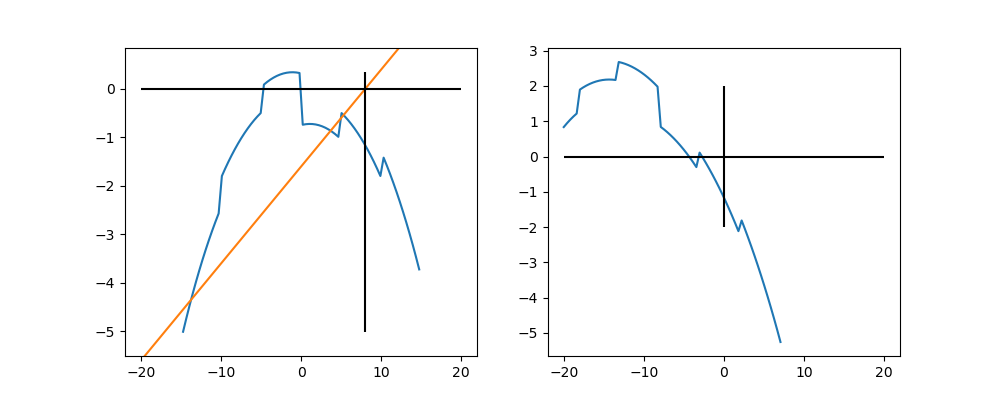

In [5]:
n_each = 3
n_rows = 2
n_cols = 1
mode = 1
dalpha = 10
dbeta = -10
dgamma = 10
alpha_cen = 0
beta_cen = 0
gamma_cen = 0
dx = 15
dy = 5
r = -25
c = 1/r
k = 0
xgap_width = 2
xgap_depth = np.nan
ygap_width = 0
ygap_depth = 2
p = ImageSlicerParams(n_each, n_rows, n_cols, mode, dalpha, dbeta, dgamma, alpha_cen, beta_cen, gamma_cen, dx, dy, c, k, xgap_width, xgap_depth, ygap_width, ygap_depth)

xt = 3
y = np.linspace(-20, 20, 100)
surf = np.zeros(len(y))
for i,y1 in enumerate(y):
    surf[i] = make_image_slicer(xt, y1, p)

t = np.linspace(-20, 20, 100)
yt = 8
l = 0
m = 1
n = 0.2
ray = (y-yt)*n/m

l = l / np.sqrt(l*l+m*m+n*n)
m = m / np.sqrt(l*l+m*m+n*n)
n = n / np.sqrt(l*l+m*m+n*n)

feval = np.zeros(len(t))
for i,t1 in enumerate(t):
    feval[i] = func_transfer(t1, xt, yt, l, m, n, p)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axs[0].plot(y, surf)
axs[0].plot(y, ray)
axs[0].set_ylim(np.nanmin(surf)-0.5, np.nanmax(surf)+0.5)
axs[0].vlines(yt, np.nanmin(surf), np.nanmax(surf), colors='k')
axs[0].hlines(0, y[0], y[-1], colors='k')

axs[1].plot(t, feval)
axs[1].hlines(0, t[0], t[-1], colors='k')
axs[1].vlines(0, -2, 2, colors='k')
#axs[1].set_ylim(-10, 10)

plt.show()

(7.00342344493503, None, -0.0)
6.969696969696969


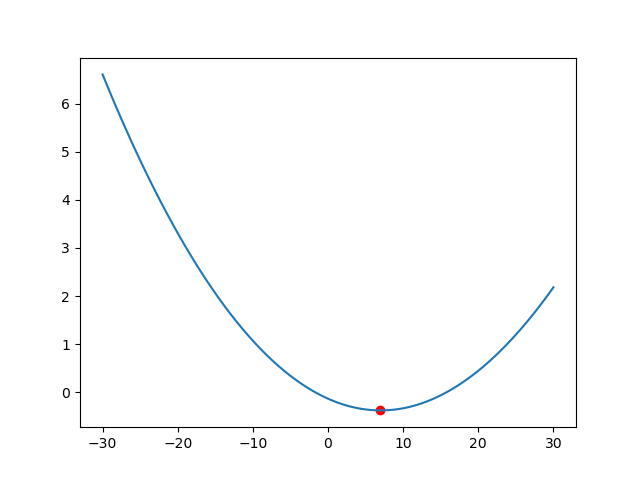

In [76]:
xs = np.linspace(-30,30,100)
y0 = 0
c = 1/100
k = -1
gamma = -5

surface = conic_3d(xs, y0, c, k, 0, 2, gamma)

print(conic_3d_sag_critical_x_y(c, k, 0, 2, gamma))

idx = np.argmin(surface)
print(xs[idx])

plt.figure()
plt.plot(xs, surface)
plt.scatter(xs[idx], surface[idx], c='r')
plt.show()

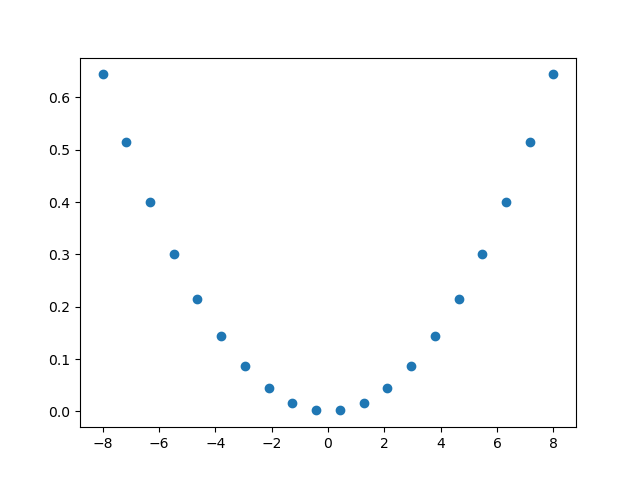

In [9]:
n_each = 1
n_rows = 1
n_cols = 1
mode = 0
dalpha = -20
dbeta = 0
dgamma = 10
alpha_cen = 0
beta_cen = 0
gamma_cen = 0
dx = 15
dy = 5
r = 50
c = 1/r
k = -1
gx_width = 0
gx_depth = np.nan
gy_width = 0
gy_depth = np.nan
p = ImageSlicerParams(n_each, n_rows, n_cols, mode, dalpha, dbeta, dgamma, alpha_cen, beta_cen, gamma_cen, dx, dy, c, k, gx_width, gx_depth, gy_width, gy_depth)

N = 20
r = 20
k = 0
t = -10

y = np.linspace(-8, 8, N)
x = np.linspace(-8, 8, N)
z = conic_3d(x, 0, c, k, 0, 0, 0)

plt.figure()
plt.scatter(x, z)
plt.show()

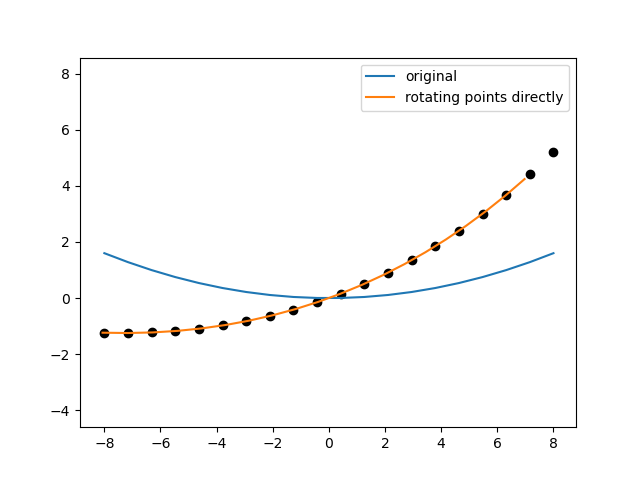

In [17]:
N = 20
r = 20
k = -1
t = 20

# perform the rotation manually with a rotation matrix
x1 = np.linspace(-8, 8, N)
y1 = []
x2 = []
y2 = []
#y3 = []
trad = -t*np.pi/180

for i in range(N):
    y1.append(conic(x1[i],r,k))
    xnew = x1[i]*np.cos(trad)+y1[i]*np.sin(trad)
    ynew = -x1[i]*np.sin(trad)+y1[i]*np.cos(trad)
    x2.append(xnew)
    y2.append(ynew)
    #y3.append(rotated_conic(x1[i], r, k, t))

y3 = conic_3d(x1, 0, 1/r, k, 0, 0, t)
plt.figure()
plt.plot(x1,y1,label='original')
plt.plot(x2,y2,label='rotating points directly')
plt.scatter(x1,y3,c='k')
#plt.vlines([-2,0,2], -1, 1)
#plt.ylim(0,8)
#plt.xlim(-8,8)
plt.axis('equal')
plt.legend()
#plt.savefig("rotated_conics.png",dpi=300,facecolor="white")
plt.show()

In [33]:
print(find_global_extrema_slicer(p))
print((np.nanmin(Z), np.nanmax(Z)))

(0.0, 4.213128989926135)
(5.457882120703622e-05, 4.1443130111941295)


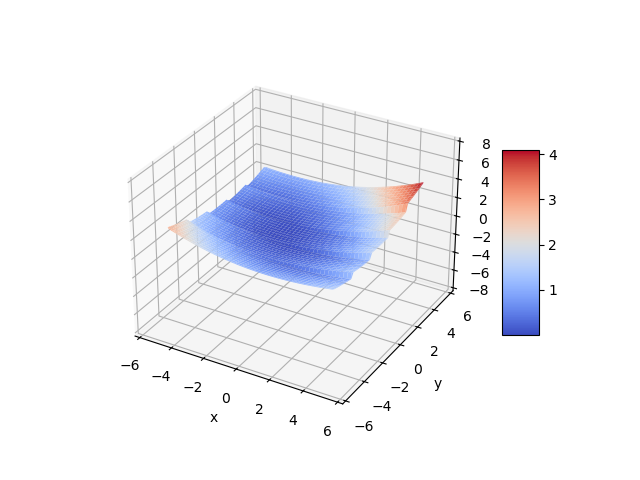

In [30]:
n_each = 5
n_rows = 1
n_cols = 1
mode = 1
dalpha = 2
dbeta = 2
dgamma = 5
alpha_cen = 0
beta_cen = 10
gamma_cen = 0
dx = 10
dy = 2
r = 10
c = 1/r
k = -1.5
xgap_width = 0
xgap_depth = -0.5
ygap_width = 0
ygap_depth = -0.8
p = ImageSlicerParams(n_each, n_rows, n_cols, mode, dalpha, dbeta, dgamma, alpha_cen, beta_cen, gamma_cen, dx, dy, c, k, xgap_width, xgap_depth, ygap_width, ygap_depth)
xsize, ysize = get_slicer_size(p)

N = 200

#Nx = n_cols * 8
#Ny = n_rows * n_each * 8
x = np.linspace(-1.1*xsize/2,1.1*xsize/2,N)
y = np.linspace(-1.1*ysize/2,1.1*ysize/2,N)

Z = np.zeros((N,N))
for i,x1 in enumerate(x):
    for j,y1 in enumerate(y):
        Z[j,i]=make_image_slicer(x1, y1, p)
        #Z[i,j]=make_image_slicer2(x1, y1, n_each, dalpha, dbeta, alpha_cen, beta_cen, dx, dy, rx, ry, kx, ky)
    

X, Y = np.meshgrid(x, y)
#Z2 = make_slice(X, Y, rx, ry, kx, ky, 0, 0)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
#ax.scatter(9.487179487179485,-4.364548494983277,-0.6999614810235664, c='g')
#ax.scatter(9.487179487179485,14.899665551839465,3.8157755724491054, c='g')
#surf = ax.plot_surface(X, Y, Z2, cmap=cm.viridis)
#ax.zaxis.set_major_formatter('{x:.02f}')
#ax.view_init(azim=90, elev=0)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlim(-8, 8)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [46]:
def rotatebackward3d(x, y, z, alpha,beta):
    alpha = convert_angle(alpha) * np.pi/180
    beta = convert_angle(beta) * np.pi/180
    cosa = np.cos(alpha)
    cosa2 = cosa*cosa
    sina = np.sin(alpha)
    sina2 = sina*sina
    cosb = np.cos(beta)
    cosb2 = cosb*cosb
    sinb = np.sin(beta)
    sinb2 = sinb*sinb
    
    # Inverse transformation matrix for a 3D rotation about the global x- and y-axes
    det = cosa2*cosb2 + cosb2*sina2 + cosa2*sinb2 + sina2*sinb2
    a = (cosa2*cosb + cosb*sina2) / det
    b = sina*sinb / det
    c = -1*cosa*sinb / det
    d = (cosa*cosb2 + cosa*sinb2) / det
    f = (cosb2*sina + sina*sinb2) / det
    g = (cosa2*sinb + sina2*sinb) / det
    h = -1*cosb*sina / det
    m = cosa*cosb / det
    xp = a*x + b*y + c*z
    yp = d*y + f*z
    zp = g*x + h*y + m*z
    #print([[a,b,c],[0,d,f],[g,h,m]])
    xp = a*x + b*y + c*z
    yp = d*y + f*z
    zp = g*x + h*y + m*z
    return xp, yp, zp

def rotateforward3d(x,y,z,alpha,beta):
    alpha = convert_angle(alpha) * np.pi/180
    beta = convert_angle(beta) * np.pi/180
    cosa = np.cos(alpha)
    cosa2 = cosa*cosa
    sina = np.sin(alpha)
    sina2 = sina*sina
    cosb = np.cos(beta)
    cosb2 = cosb*cosb
    sinb = np.sin(beta)
    sinb2 = sinb*sinb
    
    xp = x*cosb + y*sinb
    yp = x*sina*sinb + y*cosa - z*cosb*sina
    zp = -x*cosa*sinb + y*sina + z*cosa*cosb
    return xp, yp, zp


alpha=10
beta=20

N = 30
x = np.linspace(-10,10,N)
y = np.linspace(-10,10,N)

xold = []
yold = []
zold = []
xnew = []
ynew = []
znew = []

Z = np.zeros((N,N))

for i,x1 in enumerate(x):
    for j,y1 in enumerate(y):
        z1 = rotated_conic_3d(x1,y1,20,20,0,0,0,0)
        Z[i,j] = z1
        x1po, y1po, z1po = rotateforward3d(x1,y1,z1,alpha,beta)
        x1p, y1p, z1p = rotatebackward3d(x1po, y1po, z1po, alpha, beta)
        xold.append(x1po)
        yold.append(y1po)
        zold.append(z1po)
        xnew.append(x1p)
        ynew.append(y1p)
        znew.append(z1p)
    
X, Y = np.meshgrid(x, y)
#Z2 = make_slice(X, Y, rx, ry, kx, ky, 0, 0)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
ax.scatter(xold,yold,zold)
#ax.scatter(xnew,ynew,znew)
#surf = ax.plot_surface(X, Y, Z2, cmap=cm.viridis)
#ax.zaxis.set_major_formatter('{x:.02f}')
#ax.view_init(azim=90, elev=0)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlim(0, 8)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

NameError: name 'rotated_conic_3d' is not defined